In [35]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()

In [5]:
df = pd.DataFrame(boston.data , columns = boston.feature_names)
df['target'] = boston.target

In [6]:
X = df.iloc[:,df.columns != 'target']
y = df.target

In [7]:
from sklearn.preprocessing import StandardScaler
se = StandardScaler()
X = se.fit_transform(X)

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_test,y_test)

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv_ = KFold(n_splits=10)

xg_reg = xgb.XGBRegressor()

scores = cross_val_score(xg_reg, X_train,y_train , scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = cv_)
print(np.mean(scores), np.std(scores))
print(scores)

-3.0784942308511307 0.42284534035667176
[-2.62847993 -3.60582341 -3.31998107 -3.60355075 -3.03760446 -2.50243868
 -2.92302011 -2.61990331 -3.67855489 -2.8655857 ]


In [11]:
import re

def return_rmse(params):
    model = xgb.train(params , dtrain, num_boost_round = 600, evals = [(dtest, 'eval')],
          early_stopping_rounds=20,verbose_eval = 0)
    result = model.eval(dtest)
    result = np.float(re.search(r'[\d.]+$',result).group(0))
    print(result)
    return(result)

In [15]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 45.0 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 149 kB 48.1 MB/s 
     |████████████████████████████████| 113 kB 48.0 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2e786be5bb39f3463fc99322edd7a62f942e16f5e10538495ced78d37e761a68
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [16]:
import optuna
from optuna import Trial, visualization

from optuna.samplers import TPESampler

In [17]:
def objective(trial):
   
    param = {
#                 "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth', 3, 5),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
                'min_child_weight':trial.suggest_int('min_child_weight',0,5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
                'subsample':trial.suggest_uniform('subsample',0.4,0.9),

                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

In [18]:
# calling the optuna study
study1 = optuna.create_study(direction='minimize',sampler=TPESampler())
study1.optimize(objective, n_trials= 1050,show_progress_bar = True)

[I 2022-02-12 09:38:00,226] A new study created in memory with name: no-name-114adc43-dc1d-4b7c-b1b9-091bc961d30d


  0%|          | 0/1050 [00:00<?, ?it/s]

3.281448
[I 2022-02-12 09:38:00,552] Trial 0 finished with value: 3.281448 and parameters: {'max_depth': 4, 'reg_alpha': 2.423117183259582, 'reg_lambda': 0.875723809198236, 'min_child_weight': 1, 'gamma': 1.917174242924467, 'learning_rate': 0.3431199482373205, 'colsample_bytree': 0.8943072819798525, 'subsample': 0.7145378651178398}. Best is trial 0 with value: 3.281448.
3.32467
[I 2022-02-12 09:38:00,632] Trial 1 finished with value: 3.32467 and parameters: {'max_depth': 3, 'reg_alpha': 4.910809441210913, 'reg_lambda': 1.4845834666526685, 'min_child_weight': 3, 'gamma': 3.960010556438501, 'learning_rate': 0.19887436459337499, 'colsample_bytree': 0.8474726053493913, 'subsample': 0.6668302223137856}. Best is trial 0 with value: 3.281448.
3.345604
[I 2022-02-12 09:38:00,779] Trial 2 finished with value: 3.345604 and parameters: {'max_depth': 4, 'reg_alpha': 2.9456599845512272, 'reg_lambda': 0.31426694031902747, 'min_child_weight': 4, 'gamma': 0.8342928189633598, 'learning_rate': 0.0749291

In [19]:
trial = study1.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 2.949676


In [20]:
study1.best_params

{'colsample_bytree': 0.8272756095733221,
 'gamma': 0.8364053119219438,
 'learning_rate': 0.07687857171322585,
 'max_depth': 4,
 'min_child_weight': 0,
 'reg_alpha': 1.0241497733697735,
 'reg_lambda': 0.25742378200511656,
 'subsample': 0.7492651488679982}

In [21]:
params = {}
print(f"without tuning{return_rmse(params)}")
print(f"with tuning{return_rmse(study1.best_params)}")

3.214825
without tuning3.214825
2.949676
with tuning2.949676


In [22]:
#Plotting of our search history
optuna.visualization.plot_optimization_history(study1)

In [23]:
optuna.visualization.plot_slice(study1)

In [24]:
def objective(trial):
   
    param = {
#                 "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth',4,4),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,2),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.5,1),
                'min_child_weight':trial.suggest_int('min_child_weight',1,1),
                'gamma':trial.suggest_int('gamma',1,1),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.2,0.4),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.6),
                'subsample':trial.suggest_uniform('subsample',0.4,0.5),

                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

In [25]:
# calling the optuna study
study2 = optuna.create_study(direction='minimize',sampler=TPESampler())
study2.optimize(objective, n_trials= 1050,show_progress_bar = True)

[I 2022-02-12 09:43:43,664] A new study created in memory with name: no-name-4b258fd5-f926-4213-a573-8935aa65fc78


  0%|          | 0/1050 [00:00<?, ?it/s]

3.029812
[I 2022-02-12 09:43:43,796] Trial 0 finished with value: 3.029812 and parameters: {'max_depth': 4, 'reg_alpha': 0.8208163277324603, 'reg_lambda': 0.7053505360007803, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.3110642192044222, 'colsample_bytree': 0.494275505687556, 'subsample': 0.4750323080543257}. Best is trial 0 with value: 3.029812.
3.420012
[I 2022-02-12 09:43:43,857] Trial 1 finished with value: 3.420012 and parameters: {'max_depth': 4, 'reg_alpha': 0.598075163859517, 'reg_lambda': 0.9046976818669428, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.22191303265288864, 'colsample_bytree': 0.5023384819681197, 'subsample': 0.48745722849637846}. Best is trial 0 with value: 3.029812.
3.198684
[I 2022-02-12 09:43:43,914] Trial 2 finished with value: 3.198684 and parameters: {'max_depth': 4, 'reg_alpha': 0.4074156048082571, 'reg_lambda': 0.5439322493474958, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.25346124953461036, 'colsample_bytree': 0.523981136783

In [26]:
optuna.visualization.plot_optimization_history(study2)

In [27]:
study2.best_params

{'colsample_bytree': 0.46898965870381165,
 'gamma': 1,
 'learning_rate': 0.32476720618169214,
 'max_depth': 4,
 'min_child_weight': 1,
 'reg_alpha': 1.5703072769090518,
 'reg_lambda': 0.8317863357953387,
 'subsample': 0.44375210078319316}

In [29]:
params = {}
print(f"without tuning {return_rmse(params)}")
print(f"with tuning {return_rmse(study2.best_params)}")

3.214825
without tuning 3.214825
2.514436
with tuning 2.514436


[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

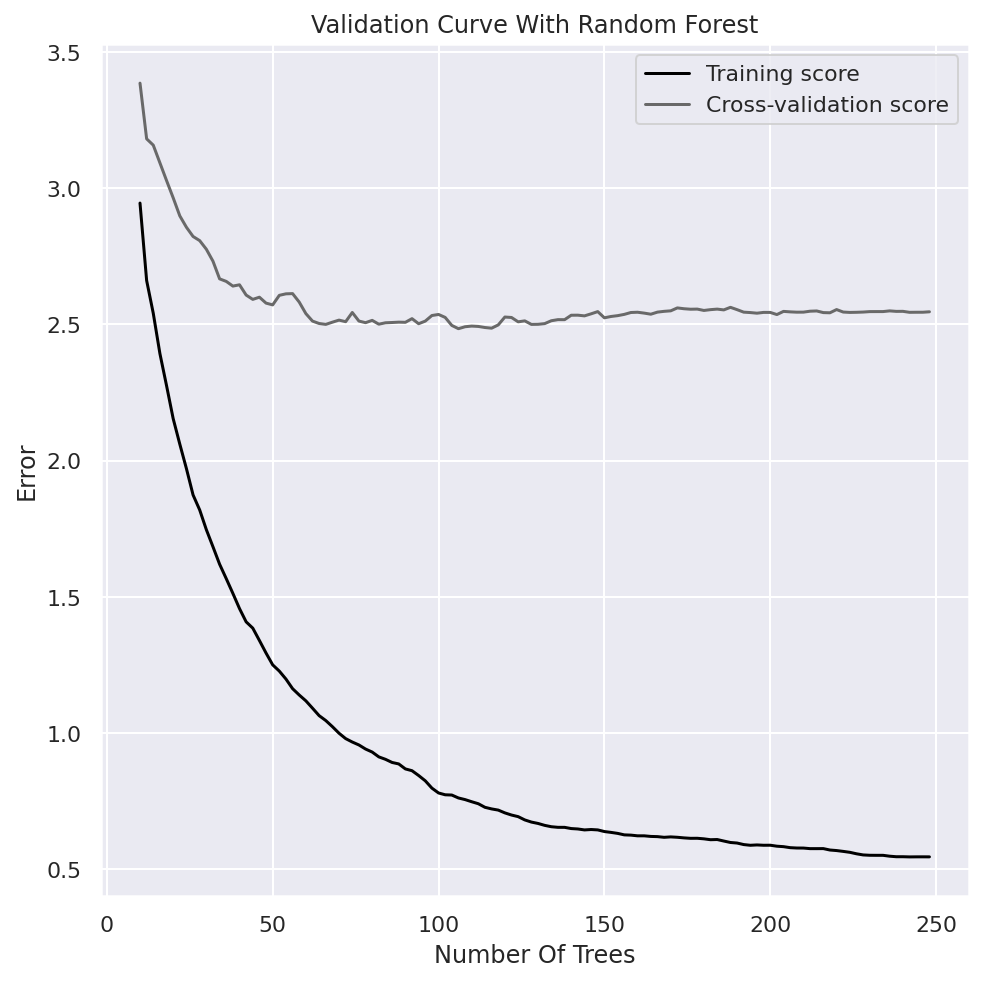

In [36]:
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings("ignore")

param_range = np.arange(10, 250, 2)

# train_scores, test_scores = validation_curve(xg_reg_base,
#                                   X, y, param_name="n_estimators", param_range=param_range,
#                                   cv=cv_shuffle, scoring="neg_root_mean_squared_error", n_jobs=-1)
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xg_reg = xgb.XGBRegressor(**study2.best_params,

        n_estimators = i

)
    xg_reg.fit(X_train,y_train)
    train_scores.append(np.sqrt(mean_squared_error(y_train,xg_reg.predict(X_train))))
    test_scores.append(np.sqrt(mean_squared_error(y_test,xg_reg.predict(X_test))))

import matplotlib.pyplot as plt

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_scores, label="Training score", color="black")
plt.plot(param_range, test_scores, label="Cross-validation score", color="dimgrey")

# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [32]:
model = xgb.train(study2.best_params , dtrain, num_boost_round = 600, evals = [(dtest, 'eval')],
          early_stopping_rounds=20,verbose_eval = 1)

[0]	eval-rmse:17.0896
Will train until eval-rmse hasn't improved in 20 rounds.
[1]	eval-rmse:12.1204
[2]	eval-rmse:9.04979
[3]	eval-rmse:6.95609
[4]	eval-rmse:5.75749
[5]	eval-rmse:4.72755
[6]	eval-rmse:3.93613
[7]	eval-rmse:3.68052
[8]	eval-rmse:3.47296
[9]	eval-rmse:3.3869
[10]	eval-rmse:3.23767
[11]	eval-rmse:3.18222
[12]	eval-rmse:3.12118
[13]	eval-rmse:3.15895
[14]	eval-rmse:3.10061
[15]	eval-rmse:3.09396
[16]	eval-rmse:3.04937
[17]	eval-rmse:3.02903
[18]	eval-rmse:3.02741
[19]	eval-rmse:2.96549
[20]	eval-rmse:2.99045
[21]	eval-rmse:2.89905
[22]	eval-rmse:2.90544
[23]	eval-rmse:2.85715
[24]	eval-rmse:2.80517
[25]	eval-rmse:2.82334
[26]	eval-rmse:2.83137
[27]	eval-rmse:2.80804
[28]	eval-rmse:2.79382
[29]	eval-rmse:2.77648
[30]	eval-rmse:2.76056
[31]	eval-rmse:2.73245
[32]	eval-rmse:2.75004
[33]	eval-rmse:2.66759
[34]	eval-rmse:2.65062
[35]	eval-rmse:2.65825
[36]	eval-rmse:2.65476
[37]	eval-rmse:2.64104
[38]	eval-rmse:2.67053
[39]	eval-rmse:2.64574
[40]	eval-rmse:2.64785
[41]	eval-r

In [37]:
xgb_regressor = xgb.XGBRegressor(**study2.best_params, n_estimators = 71)
xgb_regressor_base = xgb.XGBRegressor()

In [38]:
xgb_regressor = xgb.XGBRegressor(**study2.best_params, n_estimators = 71)
xgb_regressor_base.fit(X_train,y_train)
score1 = xgb_regressor_base.score(X_test,y_test)
xgb_regressor.fit(X_train,y_train)
score2 = xgb_regressor.score(X_test,y_test)
print(f"R2 score withouth tuning:{score1} ,R2 score with tuning:{score2}")

[09:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score withouth tuning:0.8646010514688809 ,R2 score with tuning:0.9235177814257887
